<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Red Neuronal Recurrente para el pronótico de la TRM**


Javier Arturo Rozo Alzate - jarozoa@eafit.edu.co    
Liceth Cristina Mosquera Galvis - lcmosquerg@eafit.edu.co  
Juan Diego Estrada Perez - jestra15@eafit.edu.co

Programa: Inteligencia Computacional
Docente: 	Santiago Medina Hurtado - smedinah@eafit.edu.co

10 de mayo de 2020<br>

**Importar bibliotecas**

In [1]:
import tensorflow as tf
from math import sqrt

from numpy import concatenate

import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
#from torch.autograd import Variable
import torch
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
print (tf.keras.__version__)
print (pd.__version__)

2.3.0-tf
1.0.3


**Cargar Datos**

In [2]:
df = pd.read_csv('Datos_TRM.csv', header=0, index_col=1)
#dataset.index = dataset['Date Time']
df.index.name = 'date'
df=df.drop(['Index','FF_EfcRate'], axis=1)
df.tail(5)

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
date,,,,,,,,,,,,,,,,
04/24/2020,4020.94,8.299271,0.03706,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,16.94,1735.6,-17.01,-0.004221,4008.944,3990.5985
04/27/2020,4039.87,8.303968,0.03675,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.78,1723.8,18.93,0.004697,4022.306,3988.2750
04/28/2020,4039.83,8.303958,0.03677,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.34,1722.2,-0.04,-0.000010,4036.720,3990.4750
04/29/2020,4046.04,8.305494,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,6.21,0.001536,4036.926,3990.6370
04/30/2020,3983.29,8.289863,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,-62.75,-0.015631,4025.994,3986.5610


**Analisis Exploratorio de los datos**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


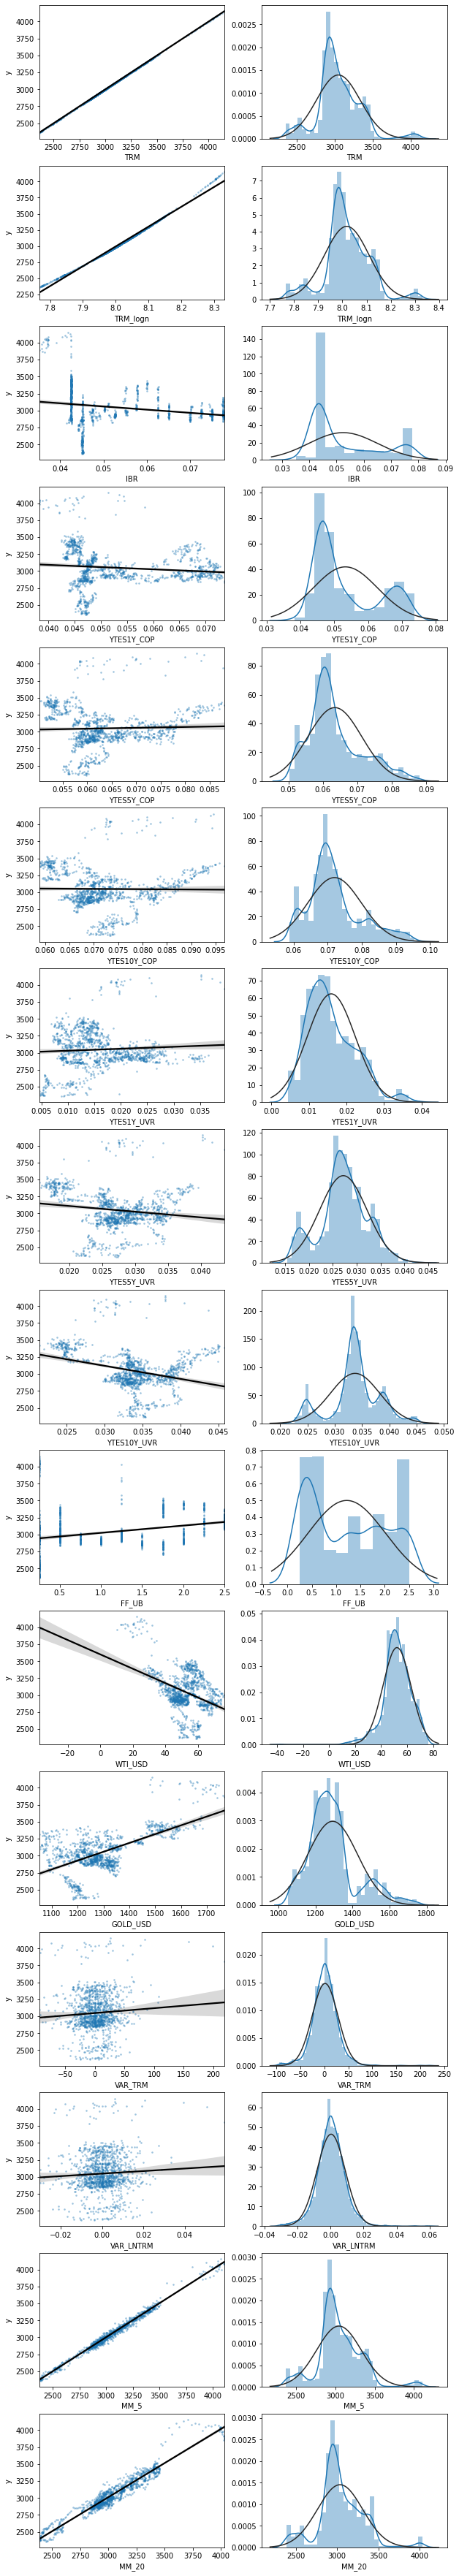

In [3]:
import seaborn as sns
from scipy import stats

df.columns
cols_continuous=['TRM', 'TRM_logn', 'IBR', 'YTES1Y_COP', 'YTES5Y_COP', 
                 'YTES10Y_COP','YTES1Y_UVR', 'YTES5Y_UVR', 'YTES10Y_UVR', 
                 'FF_UB', 'WTI_USD','GOLD_USD', 'VAR_TRM', 'VAR_LNTRM', 
                 'MM_5', 'MM_20']

# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='TRM', data=df, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('y')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df[col].dropna() , fit=stats.norm)
    plt.xlabel(col)
#import pandas_profiling
#pd.read_csv('Datos_TRM.csv').profile_report() 

ValueError: ignored

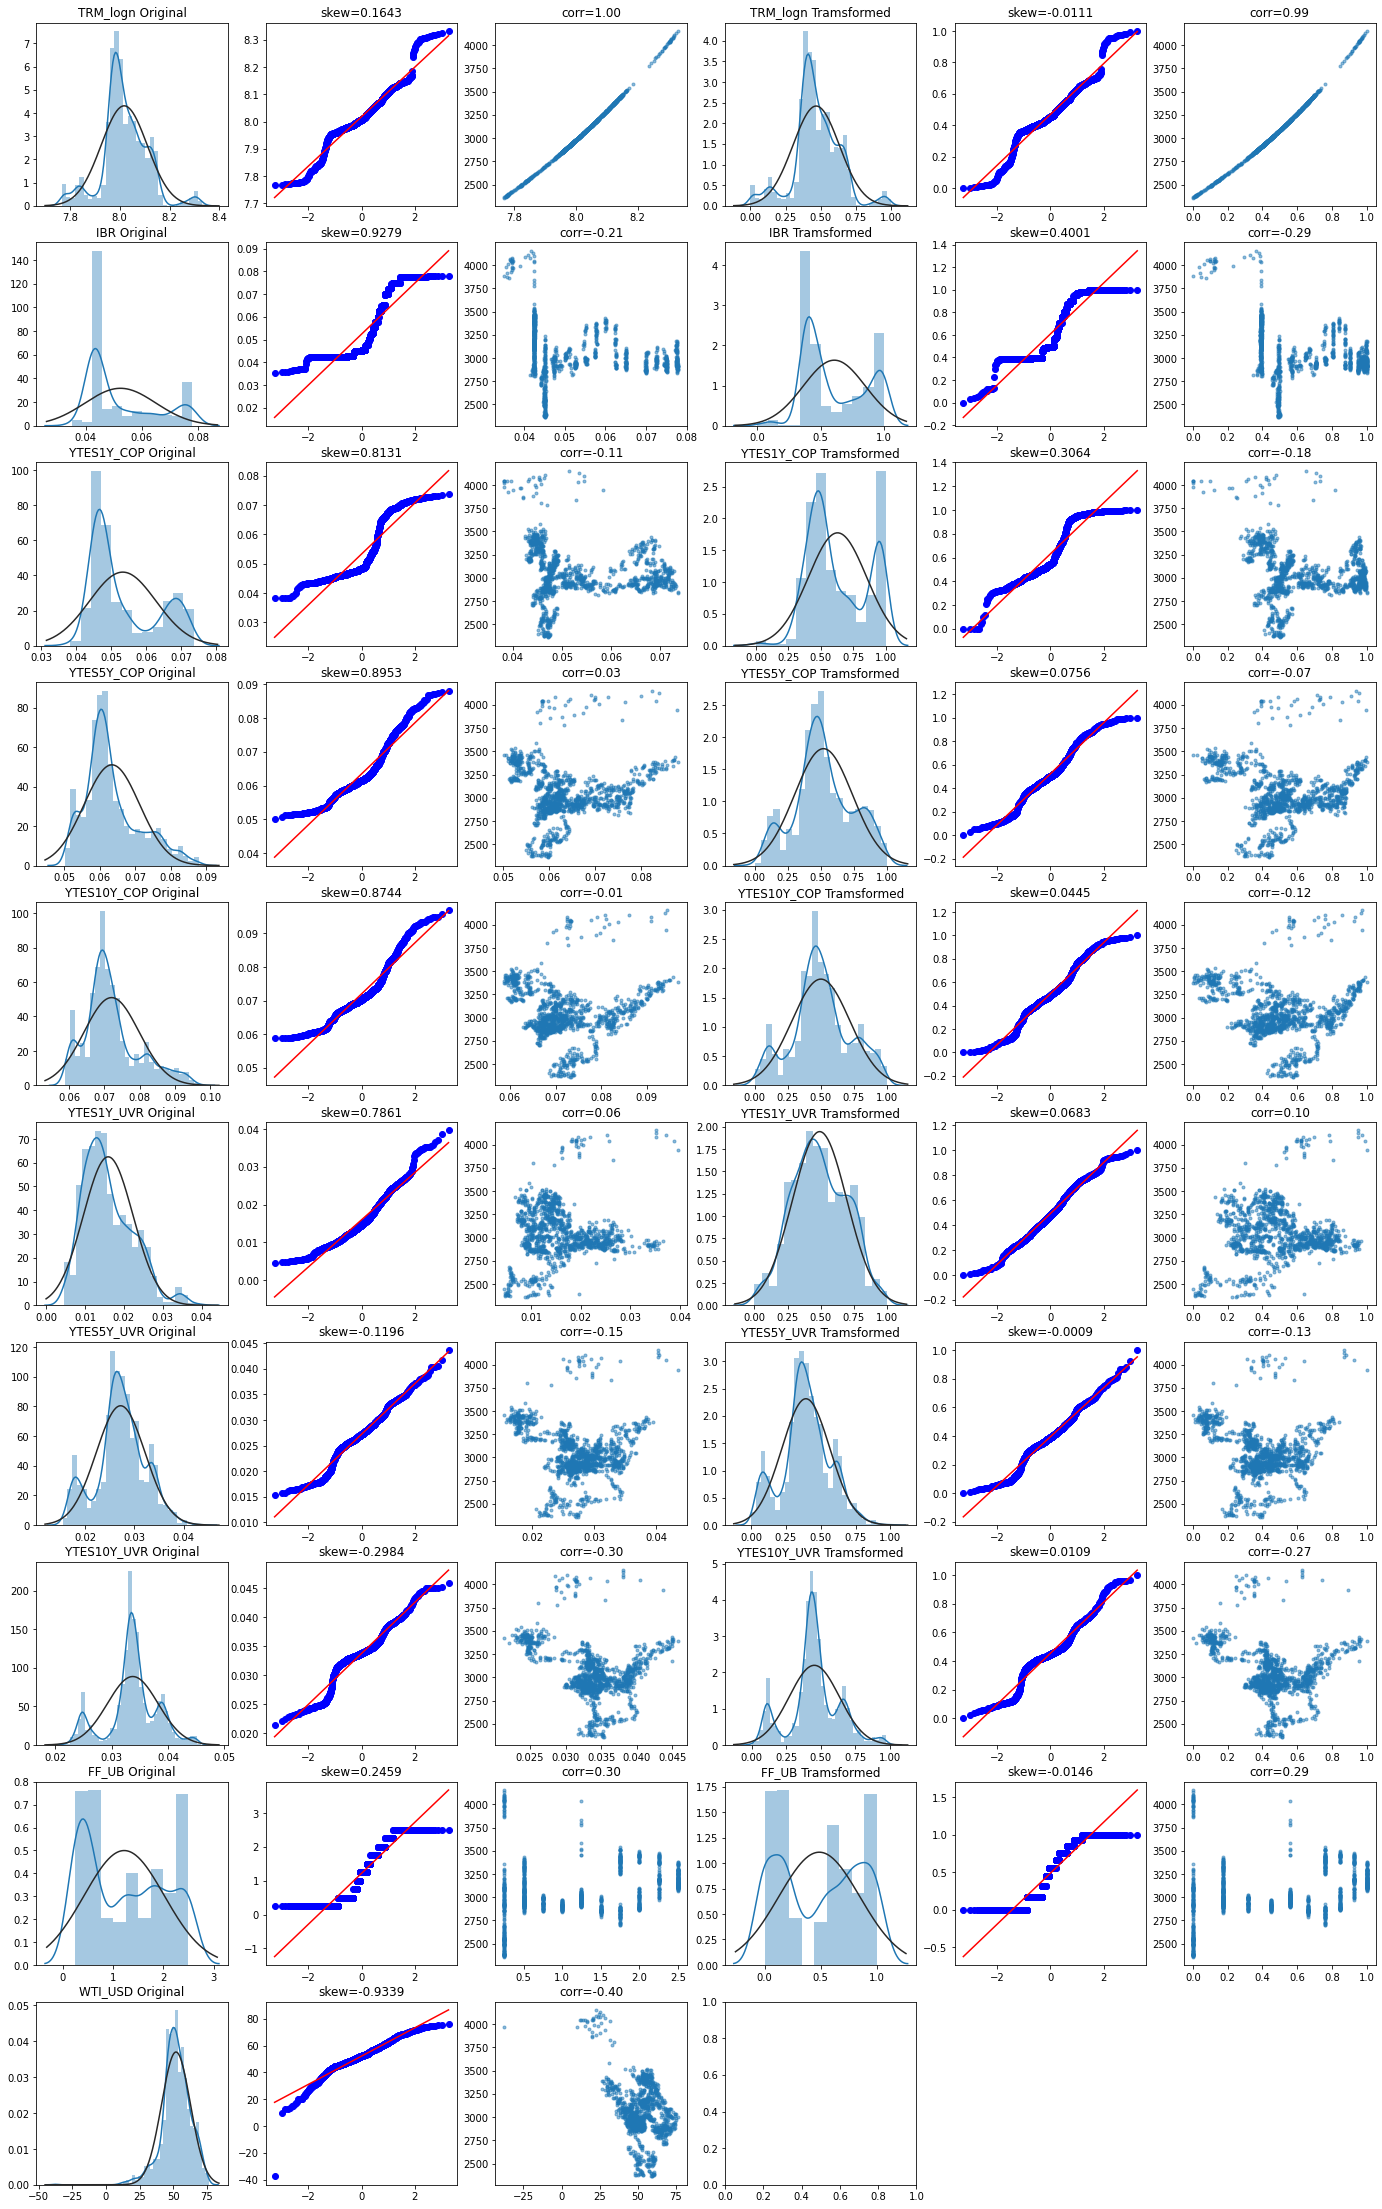

In [4]:
#Check effect of Box-Cox transforms on distributions of continuous variables
from sklearn.preprocessing import minmax_scale
import warnings
warnings.filterwarnings("ignore")
fcols = 6
frows = len(cols_continuous)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_continuous:
    if var!='TRM':
        dat = df[[var, 'TRM']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['TRM'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['TRM'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = minmax_scale(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['TRM'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['TRM'])[0][1]))

Se estandarizan todas las variables (continuas dependientes). Se divide los datos en test y training, se halla la media y la varianza del training y se transforma el test.


In [0]:
Train=df.loc['01/30/2015':'01/08/2019']
Val=df.loc['01/09/2019':'12/31/2019']
Test=df.loc['01/02/2020':'01/10/2020']

In [0]:
Train=Train.values
Train=Train.astype('float32')
Test=Test.values
Test=Test.astype('float32')
Val=Val.values
Val=Val.astype('float32')

In [7]:
scaler=StandardScaler()
Train_sc=scaler.fit_transform(Train)
Test_sc=scaler.transform(Test)
Val_sc=scaler.transform(Val)
Train_df=pd.DataFrame(Train_sc)
Test_df=pd.DataFrame(Test_sc)
Val_df=pd.DataFrame(Val_sc)
print(Train_df.shape)
print(Test_df.shape)
print(Val_df.shape)

(959, 16)
(6, 16)
(239, 16)


In [8]:
# split into input and outputs
train_X, train_y = Train_sc[:, :-1], Train_sc[:, -1]
test_X, test_y = Test_sc[:, :-1], Test_sc[:, -1]
val_X, val_y = Val_sc[:, :-1], Val_sc[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,val_X.shape,val_y.shape)

(959, 1, 15) (959,) (6, 1, 15) (6,) (239, 1, 15) (239,)


In [0]:
#conjunto de validación
validation_data = (np.expand_dims(val_X, axis=0),np.expand_dims(val_y, axis=0))

**Definir la red**
Se define como una secuencia de capas en el orden que estna conectadas al final se pone la capa de salida.

**Compilar la red**
Transformar la secuencia de capaz en matrices altamente eficientes. Especificando el algoritmo de optimización para entrenar la red y la funcion de perdida utilizada para evaluar la red que es minimizada por el algoritmo de optimización.

In [10]:
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(32,return_sequences=True,
                                    input_shape=(train_X.shape[1],train_X.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=10,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=10))
model_lstm.add(tf.keras.layers.Dense(units=1))

model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             6144      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 10)             1720      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 8,715
Trainable params: 8,715
Non-trainable params: 0
_________________________________________________________________


**Ajustar la red**
Adaptar pesos al conjunto de datos en fromación, se especifican los datos de formación. La red se forma utilizando el algoritmo de retropropagación y se optimiza de acuerdo con el algoritmo de optimización y la función de pérdida especificados al compilar el modelo.

El algoritmo de retropropagación requiere que la red sea entrenada para un número específico de épocas o exposiciones al conjunto de datos de entrenamiento. Cada época puede dividirse en grupos de pares de patrones input-output llamados lotes. Define el número de patrones a los que se expone la red antes de que se actualicen las ponderaciones dentro de una época




In [11]:
#fit network
history_lstm=model_lstm.fit(train_X,train_y,epochs=50,batch_size=5,
                            validation_data=(val_X,val_y),shuffle=False)

Epoch 1/50
192/192 [==============================] - 2s 10ms/step - loss: 0.6637 - val_loss: 1.5900
Epoch 2/50
192/192 [==============================] - 1s 4ms/step - loss: 0.4722 - val_loss: 1.0327
Epoch 3/50
192/192 [==============================] - 1s 5ms/step - loss: 0.3657 - val_loss: 1.0351
Epoch 4/50
192/192 [==============================] - 1s 5ms/step - loss: 0.2548 - val_loss: 0.8994
Epoch 5/50
192/192 [==============================] - 1s 5ms/step - loss: 0.2297 - val_loss: 0.7677
Epoch 6/50
192/192 [==============================] - 1s 4ms/step - loss: 0.2123 - val_loss: 0.6394
Epoch 7/50
192/192 [==============================] - 1s 5ms/step - loss: 0.2012 - val_loss: 0.6510
Epoch 8/50
192/192 [==============================] - 1s 4ms/step - loss: 0.1903 - val_loss: 0.6459
Epoch 9/50
192/192 [==============================] - 1s 4ms/step - loss: 0.1820 - val_loss: 0.6363
Epoch 10/50
192/192 [==============================] - 1s 5ms/step - loss: 0.1823 - val_loss: 0.572

**` Evaluar la red`**

Evaluar el rendimiento de la red en un conjunto de datos separado, no visto durante las pruebas. 


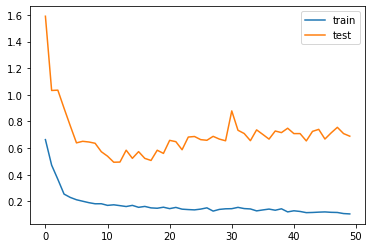

In [12]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

**Hacer prediciones**


In [0]:
#make prediction
yhatt=model_lstm.predict(val_X)
xvalt=val_X.reshape((val_X.shape[0],val_X.shape[2]))

#invert scaling for forecast
inv_yhatt=concatenate((yhatt,xvalt),axis=1) #inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhatt=scaler.inverse_transform(inv_yhatt)
inv_yhatt=inv_yhatt[:,0]

#invert scaling for actual
yvalt=val_y.reshape((len(val_y),1))
inv_yt=concatenate((yvalt,xvalt),axis=1)#inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_yt=scaler.inverse_transform(inv_yt)
inv_yt=inv_yt[:,0]

In [14]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_yt,inv_yhatt))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_yt,inv_yhatt))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_yt,inv_yhatt)))
print("R square (R^2):                  %f"% r2_score(inv_yt,inv_yhatt))

Mean absolute error (MAE):       138.804092
Mean squared error (MSE):        26238.029297
Root Mean squared error (RMSE):  161.981571
R square (R^2):                  -0.787196


<function matplotlib.pyplot.show>

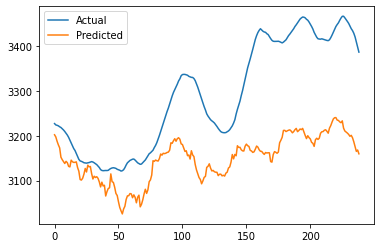

In [16]:
 plt.plot(inv_yt,label='Actual')
 plt.plot(inv_yhatt,label='Predicted')
 plt.legend()
 plt.show

**Predicción**

In [17]:
Train=df.loc['01/30/2015':'12/31/2019']
Test=df.loc['01/02/2020':'01/10/2020']
Train=Train.values
Train=Train.astype('float32')
Test=Test.values
Test=Test.astype('float32')

scaler=StandardScaler()
Train_sc=scaler.fit_transform(Train)
Test_sc=scaler.transform(Test)

Train_df=pd.DataFrame(Train_sc)
Test_df=pd.DataFrame(Test_sc)

print(Train_df.shape)
print(Test_df.shape)

# split into input and outputs
train_X, train_y = Train_sc[:, :-1], Train_sc[:, -1]
test_X, test_y = Test_sc[:, :-1], Test_sc[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1198, 16)
(6, 16)
(1198, 1, 15) (1198,) (6, 1, 15) (6,)


In [18]:
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(32,return_sequences=True,
                                    input_shape=(train_X.shape[1],train_X.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=10,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=10))
model_lstm.add(tf.keras.layers.Dense(units=1))

model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()
#
#fit network
history_lstm=model_lstm.fit(train_X,train_y,epochs=50,batch_size=5,
                            validation_data=(test_X,test_y),shuffle=False)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 32)             6144      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 10)             1720      
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 8,715
Trainable params: 8,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
240/240 [==============================] - 2s 8ms/step - loss: 0.6633 - val_loss: 0.6583
Epoch 2/50
240/240 [==============================] - 1s 4ms/step - loss: 0.3660 - val_loss: 0.0741
Epoch 3/50
240/240 [==============================

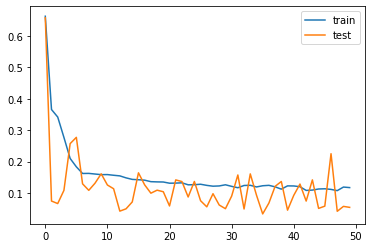

In [19]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

In [0]:
#make prediction
yhat=model_lstm.predict(test_X)
xtest=test_X.reshape((test_X.shape[0],test_X.shape[2]))

#invert scaling for forecast
inv_yhat=concatenate((yhat,xtest),axis=1) #inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhat=scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,0]

#invert scaling for actual
ytest=test_y.reshape((len(test_y),1))
inv_y=concatenate((ytest,xtest),axis=1)#inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_y=scaler.inverse_transform(inv_y)
inv_y=inv_y[:,0]

In [21]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_y,inv_yhat))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_y,inv_yhat))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_y,inv_yhat)))
print("R square (R^2):                  %f"% r2_score(inv_y,inv_yhat))

Mean absolute error (MAE):       12.601766
Mean squared error (MSE):        241.767227
Root Mean squared error (RMSE):  15.548866
R square (R^2):                  0.171509


<function matplotlib.pyplot.show>

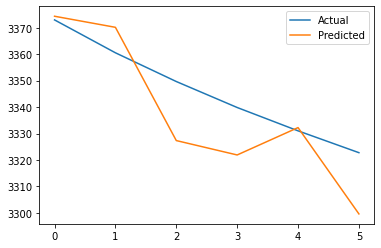

In [22]:
 plt.plot(inv_y,label='Actual')
 plt.plot(inv_yhat,label='Predicted')
 plt.legend()
 plt.show

Agregando semna y meshttps://nbviewer.jupyter.org/github/jbagnato/machine-learning/blob/master/Series_Temporales_Multivariate.ipynb

In [0]:
from sklearn.preprocessing import LabelEncoder
from pandas import concat
from pandas import DataFrame
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense,Activation,Flatten

In [0]:
df = pd.read_csv('Datos_TRM.csv', header=0, index_col=0)

# convert the 'Date' column to datetime format 
df['Date Time']= pd.to_datetime(df['Date Time']) 
  
# Check the format of 'Date' column 
df.info()

In [0]:
df.index = df['Date Time']
df.index.name = 'date'
df=df.drop(['Date Time','FF_EfcRate'], axis=1)
df.tail(5)

In [0]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

In [0]:
df.describe()

In [0]:
dummy=['weekday','month']
df2=df[dummy]
df.shape

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [0]:
PASOS=5
# load dataset
values = df.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
#values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
scaled.shape
scale = pd.DataFrame(scaled, index=df.index)
#df['scaled'] = scaled
scaledMerge=pd.concat([df2,scale],axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

In [0]:
#Dividimos en set de Entrenamiento y Validación
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

In [0]:
# split into train and test sets
values = newReframed.values
n_train_days = 1198- (76+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

In [0]:
def crear_modeloFF():
    model = Sequential() 
    #tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [0]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

In [0]:
 
# design network
model = Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [0]:
values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 2
n_features = 17
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 